<a href="https://colab.research.google.com/github/roperw42/Coursera-Getting-and-Cleaning-Data/blob/master/Copy_of_predict_the_box_office_FULL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [0]:
data = pd.read_csv("https://github.com/autumntoney/predict_the_box_office/raw/master/movie_metadata.csv")

## Taking a look at the data

You need to "run" the two cells below, to do that select the cell and press:  *`Shift-Enter`*

In [0]:
# Run this cell (to do so press Shift-Enter)
data.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,movie_title,num_voted_users,cast_total_facebook_likes,actor_3_name,facenumber_in_poster,plot_keywords,movie_imdb_link,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.00,178.00,0.00,855.00,Joel David Moore,"1,000.00","760,505,847.00",Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,886204,4834,Wes Studi,0.00,avatar|future|marine|native|paraplegic,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,"3,054.00",English,USA,PG-13,"237,000,000.00","2,009.00",936.00,7.90,1.78,33000
1,Color,Gore Verbinski,302.00,169.00,563.00,"1,000.00",Orlando Bloom,"40,000.00","309,404,152.00",Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,471220,48350,Jack Davenport,0.00,goddess|marriage ceremony|marriage proposal|pi...,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,"1,238.00",English,USA,PG-13,"300,000,000.00","2,007.00","5,000.00",7.10,2.35,0
2,Color,Sam Mendes,602.00,148.00,0.00,161.00,Rory Kinnear,"11,000.00","200,074,175.00",Action|Adventure|Thriller,Christoph Waltz,Spectre,275868,11700,Stephanie Sigman,1.00,bomb|espionage|sequel|spy|terrorist,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,994.00,English,UK,PG-13,"245,000,000.00","2,015.00",393.00,6.80,2.35,85000
3,Color,Christopher Nolan,813.00,164.00,"22,000.00","23,000.00",Christian Bale,"27,000.00","448,130,642.00",Action|Thriller,Tom Hardy,The Dark Knight Rises,1144337,106759,Joseph Gordon-Levitt,0.00,deception|imprisonment|lawlessness|police offi...,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,"2,701.00",English,USA,PG-13,"250,000,000.00","2,012.00","23,000.00",8.50,2.35,164000
4,NaN,Doug Walker,nan,nan,131.00,nan,Rob Walker,131.00,nan,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,8,143,NaN,0.00,NaN,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,nan,NaN,NaN,NaN,nan,nan,12.00,7.10,nan,0


In [0]:
data.shape

(5043, 28)

In [0]:
data.describe()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
count,"4,993.00","5,028.00","4,939.00","5,020.00","5,036.00","4,159.00","5,043.00","5,043.00","5,030.00","5,022.00","4,551.00","4,935.00","5,030.00","5,043.00","4,714.00","5,043.00"
mean,140.19,107.20,686.51,645.01,"6,560.05","48,507,385.63","83,668.16","9,699.06",1.37,272.77,"39,752,620.44","2,002.47","1,651.75",6.44,2.22,"7,525.96"
std,121.60,25.20,"2,813.33","1,665.04","15,020.76","68,471,915.43","138,485.26","18,163.80",2.01,377.98,"206,114,898.45",12.47,"4,042.44",1.13,1.39,"19,320.45"
min,1.00,7.00,0.00,0.00,0.00,162.00,5.00,0.00,0.00,1.00,218.00,"1,916.00",0.00,1.60,1.18,0.00
25%,50.00,93.00,7.00,133.00,614.00,"5,351,178.00","8,593.50","1,411.00",0.00,65.00,"6,000,000.00","1,999.00",281.00,5.80,1.85,0.00
50%,110.00,103.00,49.00,371.50,988.00,"25,528,495.00","34,359.00","3,090.00",1.00,156.00,"20,000,000.00","2,005.00",595.00,6.60,2.35,166.00
75%,195.00,118.00,194.50,636.00,"11,000.00","62,319,957.00","96,309.00","13,756.50",2.00,326.00,"45,000,000.00","2,011.00",918.00,7.20,2.35,"3,000.00"
max,813.00,511.00,"23,000.00","23,000.00","640,000.00","760,505,847.00","1,689,764.00","656,730.00",43.00,"5,060.00","12,215,500,000.00","2,016.00","137,000.00",9.50,16.00,"349,000.00"


Some key points from this table:
- Avg movie duration is 107.2 minutes
- Avg imdb is 6.44
- Avg number of users reviews is 272

## Cleaning the data

### Dealing with duplicates


In [0]:
print ('Number of duplicates in data: {}'.format(
    sum(data.duplicated(subset=['movie_title', 'title_year'], keep=False))))

Number of duplicates in data: 241


In [0]:
data = data.drop_duplicates(subset=['movie_title', 'title_year'], keep='first').copy()

### Fixing Null and some zero values

In [0]:
# check if data has any null/nan values
data.isnull().values.any()

True

In [0]:
# Check how many values are null in each column
def show_missing_data(data):
    missing_data = data.isnull().sum().reset_index()
    missing_data.columns = ['column_name', 'missing_count']
    missing_data['filling_factor'] = (data.shape[0] - missing_data['missing_count']) / data.shape[0] * 100
    return missing_data.sort_values('filling_factor').reset_index(drop=True)

show_missing_data(data)[:5]

,column_name,missing_count,filling_factor
0,gross,863,82.46
1,budget,485,90.14
2,aspect_ratio,326,93.37
3,content_rating,301,93.88
4,plot_keywords,152,96.91


As we are working with the Gross Box Office, rows without it are of no use. So we will exclude those films that are missing the Gross Box Office.

In [0]:
data.dropna(subset=['gross'], how='all', inplace=True)
show_missing_data(data)[:5]

,column_name,missing_count,filling_factor
0,budget,266,93.44
1,aspect_ratio,104,97.44
2,content_rating,64,98.42
3,plot_keywords,40,99.01
4,actor_3_name,13,99.68


Fill out missing budget datapoints with the median budget for the year it was released.

In [0]:
median_budget_per_year = data.groupby('title_year')['budget'].transform('median')
data['budget'].fillna(median_budget_per_year, inplace=True)

show_missing_data(data)[:5]

,column_name,missing_count,filling_factor
0,aspect_ratio,104,97.44
1,content_rating,64,98.42
2,plot_keywords,40,99.01
3,actor_3_name,13,99.68
4,actor_3_facebook_likes,13,99.68


Fill out the rest of the missing data

In [0]:
data.fillna(0, inplace=True)

Delete all rows where `title_year` is zero

In [0]:
data = data[data['title_year'] != 0]

Budgets are in each country's currency so we are going to use only US movies

In [0]:
data = data[data['country'] == 'USA']

## Understanding the data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ae4e86160>]],
      dtype=object)

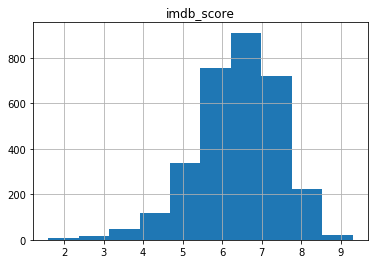

In [0]:
# IMDb rating distribution
data.hist(column='imdb_score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ad4c912b0>]],
      dtype=object)

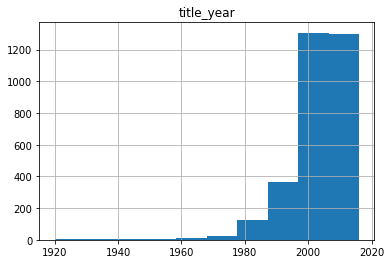

In [0]:
# Movies per year
data.hist(column='title_year')

Text(0.5,0,'Gross (in million)')

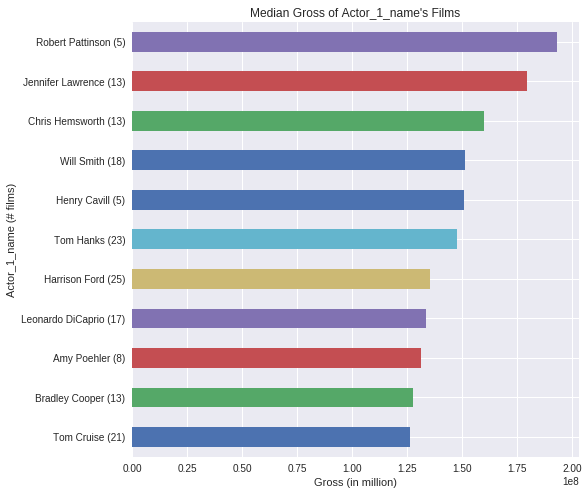

In [0]:
# Median gross box office per actor
fig = plt.figure(figsize=(8,8))
comparison_df = data.groupby('actor_1_name', as_index=False).mean().sort_values('gross', ascending=False)

name_count_key = data['actor_1_name'].value_counts().to_dict()
comparison_df['films'] = comparison_df['actor_1_name'].map(name_count_key)

comparison_df['actor_1_name'] = comparison_df['actor_1_name'].map(str) + " (" + comparison_df['films'].astype(str) + ")"

comparison_df[comparison_df['films'] >= 5][['actor_1_name', 'gross']][10::-1].set_index('actor_1_name').iloc[:,0].plot(kind='barh')
plt.legend().set_visible(False)
plt.title("Median Gross of Actor_1_name's Films")
plt.ylabel("Actor_1_name (# films)")
plt.xlabel("Gross (in million)")

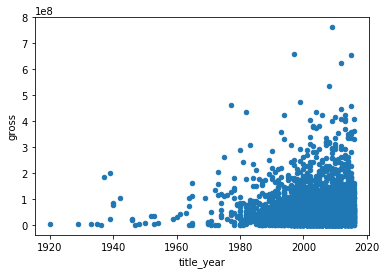

In [0]:
# title year vs gross
data.plot.scatter(x='title_year', y='gross')

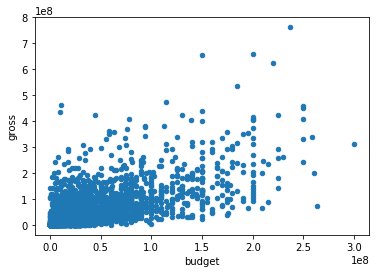

In [0]:
# budget vs gross
data.plot.scatter(x='budget', y='gross')

In [0]:
data.corr()

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
num_critic_for_reviews,1.00,0.28,0.19,0.28,0.18,0.49,0.61,0.25,-0.03,0.58,0.49,0.39,0.28,0.36,0.24,0.70
duration,0.28,1.00,0.21,0.14,0.10,0.29,0.37,0.14,0.01,0.37,0.30,-0.11,0.15,0.38,0.18,0.25
director_facebook_likes,0.19,0.21,1.00,0.13,0.09,0.14,0.32,0.12,-0.05,0.25,0.10,-0.06,0.12,0.22,0.06,0.18
actor_3_facebook_likes,0.28,0.14,0.13,1.00,0.25,0.28,0.27,0.47,0.10,0.22,0.27,0.12,0.54,0.09,0.07,0.30
actor_1_facebook_likes,0.18,0.10,0.09,0.25,1.00,0.13,0.18,0.95,0.06,0.13,0.15,0.09,0.38,0.12,0.07,0.13
gross,0.49,0.29,0.14,0.28,0.13,1.00,0.64,0.22,-0.03,0.56,0.65,0.03,0.24,0.26,0.13,0.38
num_voted_users,0.61,0.37,0.32,0.27,0.18,0.64,1.00,0.25,-0.04,0.79,0.42,0.02,0.25,0.50,0.14,0.53
cast_total_facebook_likes,0.25,0.14,0.12,0.47,0.95,0.22,0.25,1.00,0.08,0.19,0.23,0.12,0.62,0.13,0.09,0.21
facenumber_in_poster,-0.03,0.01,-0.05,0.10,0.06,-0.03,-0.04,0.08,1.00,-0.08,-0.03,0.08,0.07,-0.08,0.01,0.01
num_user_for_reviews,0.58,0.37,0.25,0.22,0.13,0.56,0.79,0.19,-0.08,1.00,0.42,0.02,0.20,0.34,0.15,0.40


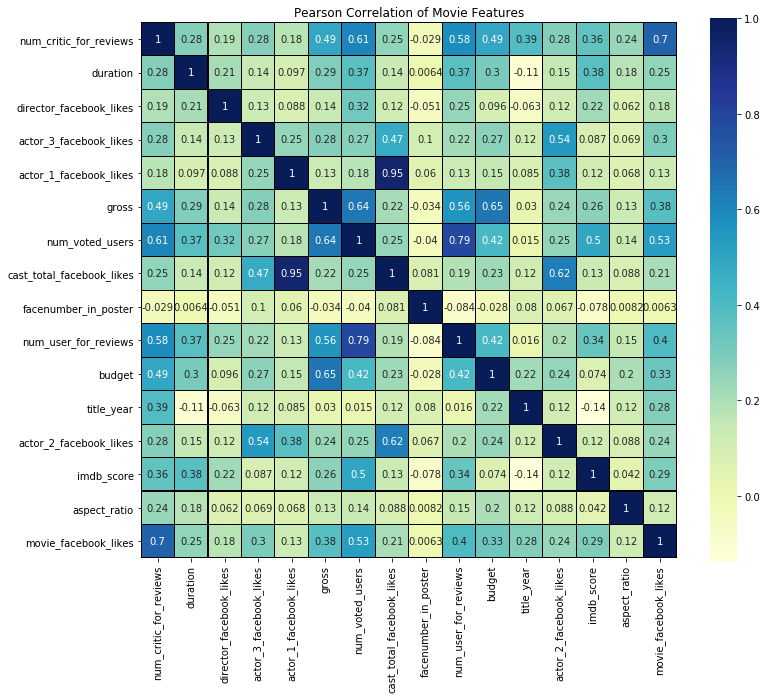

In [0]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
plt.title('Pearson Correlation of Movie Features')

# Draw the heatmap using seaborn
sns.heatmap(data.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="YlGnBu", linecolor='black', annot=True)

As we can see from the heatmap, there are regions (features) where we can see quite positive linear correlations amongst each other, given the darker shade of the colours - top left-hand corner and bottom right quarter. This is a good sign as it means we may be able to find linearly correlated features for which we can perform PCA projections on.

In [0]:
data.corr()['gross'].sort_values(ascending=False)

gross                        1.00
budget                       0.65
num_voted_users              0.64
num_user_for_reviews         0.56
num_critic_for_reviews       0.49
movie_facebook_likes         0.38
duration                     0.29
actor_3_facebook_likes       0.28
imdb_score                   0.26
actor_2_facebook_likes       0.24
cast_total_facebook_likes    0.22
director_facebook_likes      0.14
actor_1_facebook_likes       0.13
aspect_ratio                 0.13
title_year                   0.03
facenumber_in_poster        -0.03
Name: gross, dtype: float64


The gross box office correlates strongly with num_voted_users, num_users_for_reviews and movie_facebook_likes. But some of those features are also highly correlated among each other (as you can see in the heatmap above).



## Gross Box Office Prediction


### Getting numerical data


In [0]:
numerical_columns = data.dtypes[data.dtypes != 'object'].index
numerical_data = data[numerical_columns]

# we drop aspect_ratio, as it doesn't provide any useful info
numerical_data.drop('aspect_ratio', axis=1, inplace=True)
numerical_data.head(2)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
0,723.00,178.00,0.00,855.00,"1,000.00","760,505,847.00",886204,4834,0.00,"3,054.00","237,000,000.00","2,009.00",936.00,7.90,33000
1,302.00,169.00,563.00,"1,000.00","40,000.00","309,404,152.00",471220,48350,0.00,"1,238.00","300,000,000.00","2,007.00","5,000.00",7.10,0


### Preparing train and test datasets

In [0]:
train, test = train_test_split(numerical_data, test_size=0.2)
target_train = train.pop('gross')
target_test = test.pop('gross')

In [0]:
print('Train data: {} / {} = {}'.format(len(train), len(numerical_data), float(len(train)/len(numerical_data))))
print('Test data: {} / {} = {}'.format(len(test), len(numerical_data), float(len(test)/len(numerical_data))))

Train data: 2523 / 3154 = 0.7999365884590995
Test data: 631 / 3154 = 0.20006341154090043


### Linear Regression

In [0]:
model = LinearRegression()
model.fit(train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
prediction = model.predict(test)

Mean squared error: 1918460624674092.25
Variance score: 0.57


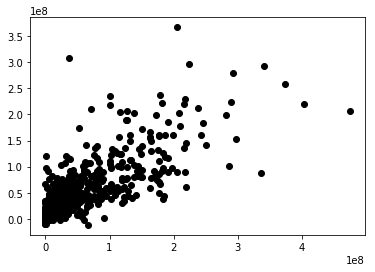

In [0]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(target_test, prediction))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(target_test, prediction))

# Plot outputs
plt.scatter(target_test, prediction,  color='black')
# plt.plot(test, prediction, color='blue', linewidth=3)


plt.show()

### Random Forest

In [0]:
forest = RandomForestRegressor(
    max_depth=25,
    min_samples_split=15,
    n_estimators=1000,
    random_state=1)

forest.fit(train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [0]:
forest.feature_importances_

array([0.02413134, 0.02765885, 0.01393902, 0.01240572, 0.01050073,
       0.55235898, 0.01496232, 0.00404773, 0.02646801, 0.23166686,
       0.03850142, 0.01327553, 0.01721769, 0.01286579])

In [0]:
forest_prediction = forest.predict(test)

Mean squared error: 1607280846760087.25
Variance score: 0.64


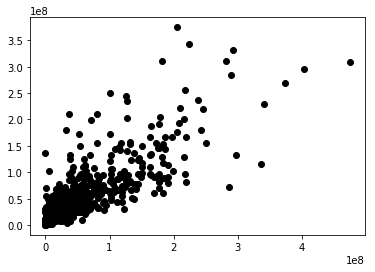

In [0]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(target_test, forest_prediction))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(target_test, forest_prediction))

# Plot outputs
plt.scatter(target_test, forest_prediction,  color='black')
# plt.plot(test, prediction, color='blue', linewidth=3)


plt.show()

## Dropping post-fact data

There are post-fact variables in our data set making the prediction more accurate. Things like `num_voted_users` and `num_user_for_reviews` are after the fact metrics, so probably not as useful for prediction.

In [0]:
train.head(2)

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,movie_facebook_likes
2439,104.00,109.00,128.00,"1,000.00","11,000.00",23728,14995,0.00,213.00,"18,000,000.00","2,001.00","2,000.00",6.10,813
1455,137.00,101.00,48.00,531.00,775.00,43991,3001,2.00,695.00,"35,000,000.00","2,002.00",541.00,5.20,0


In [0]:
train.drop(['num_critic_for_reviews', 'num_voted_users', 'num_user_for_reviews', 'imdb_score', 'movie_facebook_likes'], axis=1, inplace=True)
test.drop(['num_critic_for_reviews', 'num_voted_users', 'num_user_for_reviews', 'imdb_score', 'movie_facebook_likes'], axis=1, inplace=True)
train.head(2)

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,budget,title_year,actor_2_facebook_likes
2439,109.00,128.00,"1,000.00","11,000.00",14995,0.00,"18,000,000.00","2,001.00","2,000.00"
1455,101.00,48.00,531.00,775.00,3001,2.00,"35,000,000.00","2,002.00",541.00


In [0]:
pre_data_forest = RandomForestRegressor(
    max_depth=25,
    min_samples_split=15,
    n_estimators=1000,
    random_state=1)

pre_data_forest.fit(train, target_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=15,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [0]:
second_prediction = pre_data_forest.predict(test)

Mean squared error: 2479247443817150.50
Variance score: 0.44


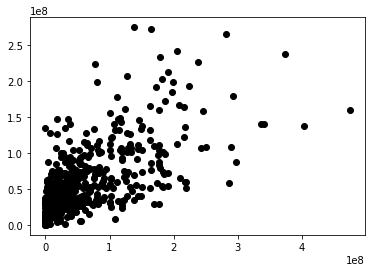

In [0]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(target_test, second_prediction))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(target_test, second_prediction))

# Plot outputs
plt.scatter(target_test, second_prediction,  color='black')
# plt.plot(test, prediction, color='blue', linewidth=3)


plt.show()

## Over/Under performing movies

In [0]:
numerical_data_target = numerical_data.pop('gross')
all_data_prediction = forest.predict(numerical_data)

In [0]:
performance_df = data.copy()

performance_df["prediction"] = all_data_prediction
performance_df["performance_diff"] = numerical_data_target - all_data_prediction

performance_df.sort_values(['performance_diff'], ascending=False, inplace=True)

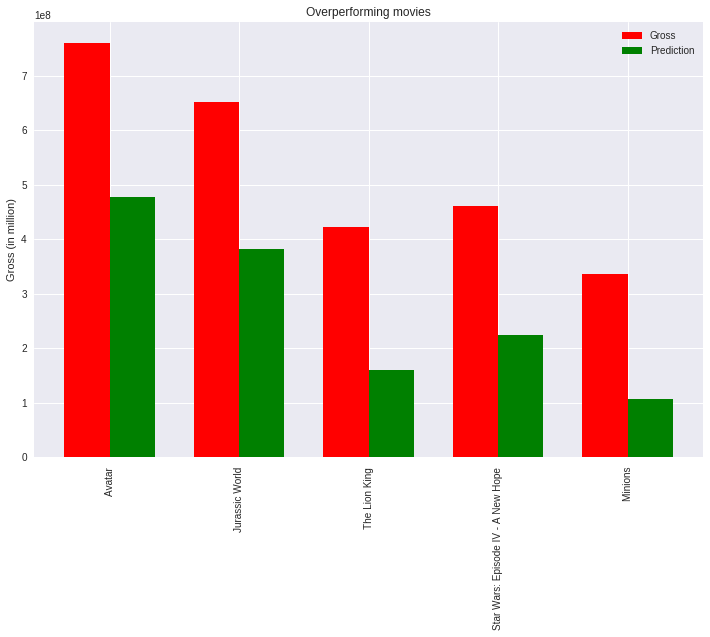

In [0]:
ind = np.arange(5)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

gross = ax.bar(ind, performance_df.gross[:5], width, color='r')
predicted_gross = ax.bar(ind + width, performance_df.prediction[:5], width, color='g')

plt.title("Overperforming movies")
plt.ylabel("Gross (in million)")

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(performance_df.movie_title[:5], rotation='vertical')
ax.legend((gross[0], predicted_gross[0]), ('Gross', 'Prediction'))

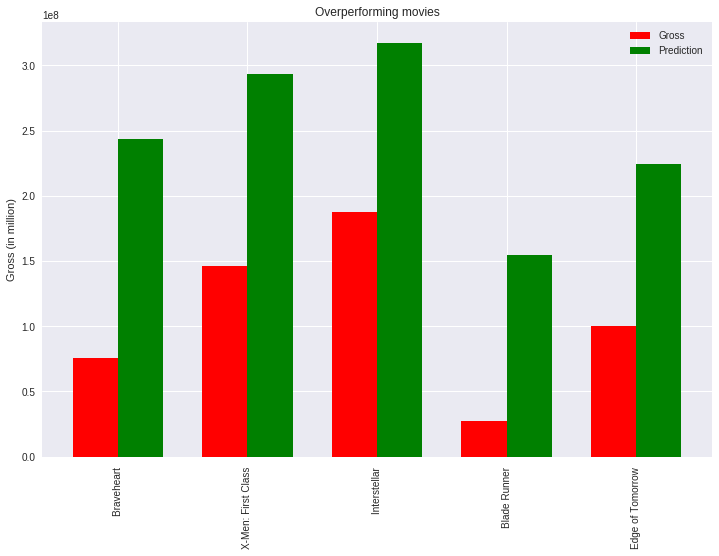

In [0]:


ind = np.arange(5)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))

gross = ax.bar(ind, performance_df.gross[:-6:-1], width, color='r')
predicted_gross = ax.bar(ind + width, performance_df.prediction[:-6:-1], width, color='g')

plt.title("Overperforming movies")
plt.ylabel("Gross (in million)")

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(performance_df.movie_title[:-6:-1], rotation='vertical')
ax.legend((gross[0], predicted_gross[0]), ('Gross', 'Prediction'))